### 5.4 단순한 계층 구현하기

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### 곱셈 노드
class MulLayer(): 
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        return self.x * self.y
    
    def backward(self, dout):
        return dout * self.y, dout * self.x

In [3]:
mul_apple = MulLayer()
mul_tax = MulLayer()

In [4]:
apple_num = 2
apple = 100
tax = 1.1

apple_price = mul_apple.forward(apple, apple_num)
price = mul_tax.forward(apple_price, tax)
price

220.00000000000003

In [5]:
dprice = 1
dapple_price, dtax = mul_tax.backward(dprice)
dapple_price, dtax

dapple, dapple_num = mul_apple.backward(dapple_price)
dapple, dapple_num

(2.2, 110.00000000000001)

In [6]:
### 덧셈 노드
class AddLayer:
    def __init__(self):
        pass
    
    # self.x = x, self.y = y 안한 이유: x, y값 저장할 필요가 없음    
    def forward(self, x, y):
        return x + y
        
    def backward(self, dout):
        return dout * 1, dout * 1

In [7]:
mul_apple = MulLayer()
mul_orange = MulLayer()
mul_tax = MulLayer()
add_apple_orange = AddLayer()

In [8]:
apple_num = 2
apple = 100
orange_num = 3
orange = 150
tax = 1.1

apple_price = mul_apple.forward(apple_num, apple)
orange_price = mul_orange.forward(orange, orange_num)
apple_orange_price = add_apple_orange.forward(apple_price, orange_price)
price = mul_tax.forward(apple_orange_price, tax)

In [9]:
dprice = 1

dapple_orange_price, dtax = mul_tax.backward(dprice)
dapple_price, dorange_price = add_apple_orange.backward(dapple_orange_price)
dorange, dorange_num = mul_orange.backward(dorange_price)
dapple_num, dapple = mul_apple.backward(dapple_price)
dapple_num, dapple 

(110.00000000000001, 2.2)

### 5.5 활성화 함수 계층 구현하기

In [10]:
### ReLU 계층 구현
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
        
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

In [11]:
x = np.array([[1.0, -2.0], [3.1, -4.0]])
mask = (x <= 0)
out = x.copy()
out[mask] = 0
out

array([[1. , 0. ],
       [3.1, 0. ]])

In [12]:
dout = np.array([[-1.0, 2.0], [3.1, -4.0]])
mask = (dout <= 0)
dout[mask] = 0
dout

array([[0. , 2. ],
       [3.1, 0. ]])

In [13]:
a = Relu()

In [14]:
x = np.array([[1.0, -2.0], [3.1, -4.0]])
a.forward(x)

array([[1. , 0. ],
       [3.1, 0. ]])

In [15]:
dout = np.array([[-1.0, 2.0], [3.1, -4.0]])
a.backward(dout)

array([[-1. ,  0. ],
       [ 3.1,  0. ]])

In [16]:
### sigmoid 계층
class Sigmoid:
    def __init__(self):
        self.y = None
    
    def forward(self, x):
        self.y = 1 / (1 + np.exp(-x))
        return self.y
        
    def backward(self, dout):
        dx = dout * self.y * (1.0 - self.y)
        return dx

### 5.6 Affine/Softmax 계층 구현하기

In [17]:
x = np.random.rand(2)
W = np.random.rand(2,3)
b = np.random.rand(3)

y = np.dot(x, W) + b
y

array([0.74870454, 0.88938289, 0.96453029])

In [18]:
x.shape, W.shape, b.shape, y.shape

((2,), (2, 3), (3,), (3,))

In [19]:
X_dot_W = np.array([[0,0,0],[10,10,10]])
B = np.array([1,2,3])
X_dot_W + B

array([[ 1,  2,  3],
       [11, 12, 13]])

In [20]:
dY = np.array([[1,2,3],[4,5,6]])
dY

array([[1, 2, 3],
       [4, 5, 6]])

In [21]:
dB = np.sum(dY, axis=0)
dB

array([5, 7, 9])

In [22]:
### affine 계층 구현
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dw = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        return np.dot(self.x, self.W) + self.b
        
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dw = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx

In [23]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

In [24]:
def cross_entropy_error(y, t):
    delta = 1e-7
    if y.ndim == 1:
        y = y.reshape(1, y.shape[0])
        t = t.reshape(1, t.shape[0])
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + delta)) / batch_size

In [25]:
### softmax-with-loss 계층 구현
class SoftMaxWithLoss:
    def __init__(self):
        self.y = None
        self.t = None
        self.loss = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
        
    def backward(self, dout=1):
        batch_size = self.y.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

### 5.7 오차역전파법 구현하기

In [26]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from collections import OrderedDict

In [27]:
def numerical_gradient_1d(f,x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2)/(2*h)
        x[idx] = tmp_val
    return grad

In [28]:
def numerical_gradient(f,x):
    if x.ndim == 1:
        return numerical_gradient_1d(f,x)
    else:
        grad = np.zeros_like(x)
        
        for idx, x1 in enumerate(x):
            grad[idx] = numerical_gradient_1d(f, x1)
            
        return grad

In [29]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer = SoftMaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
        
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y,t)
        
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        return np.sum(y == t) / float(x.shape[0])
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x,t) 
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
        
    def gradient(self, x, t):
        # 순전파
        self.loss(x,t)
        
        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Affine1'].dw
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dw
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

In [30]:
params = {}
params['W1'] = np.random.rand(2,3)
params['b1'] = np.zeros(3)
params['W2'] = np.random.rand(3,3)
params['b2'] = np.zeros(3)

layers = {}
layers['Affine1'] = Affine(params['W1'], params['b1'])
layers['Relu'] = Sigmoid()
layers['Affine2'] = Affine(params['W2'], params['b2'])

In [31]:
x = np.array([2.0,3.0])
for layer in layers.values():
    x = layer.forward(x)
    print(x)

[2.51819707 1.96706457 4.79914141]
[0.9254077  0.87729547 0.99183047]
[0.65133543 0.89853384 1.84691169]


In [32]:
list(layers.values())

In [33]:
y = np.array([[1.0,3.2],[4.2,5.5],[1.2,3.5]])
t = np.array([[0,1],[0,1],[0,1]])
y = np.argmax(y, axis=1)
t = np.argmax(t, axis=1)

np.sum(y == t) / 2.0

1.5

### 5.7.3 오차역전파법으로 구한 기울기 검증

In [34]:
from dataset.mnist import load_mnist

In [35]:
(x_train,t_train), (x_test,t_test) = load_mnist(normalize=True, one_hot_label=True, flatten =True)

In [36]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [37]:
x_batch = x_train[:3]
t_batch = t_train[:3]

In [38]:
grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backpro = network.gradient(x_batch, t_batch)

In [39]:
for key in grad_backpro.keys():
    diff = np.average(np.abs(grad_backpro[key] - grad_numerical[key]))
    print(f'{key} : {diff}')

W1 : 9.470842229057756e-07
b1 : 1.0555112420272611e-05
W2 : 5.089927474681804e-09
b2 : 1.3997543656940615e-07


In [40]:
diff = np.average(np.abs(grad_backpro['W1'] - grad_numerical['W1']))
print(diff)

9.470842229057756e-07


### 5.7.4 오차역전파법을 사용한 학습 구현하기

In [41]:
(x_train,t_train), (x_test,t_test) = load_mnist(normalize=True, one_hot_label=True)

In [42]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [43]:
iters_num = 10000
batch_size = 100
learning_rate = 0.1
train_size = x_train.shape[0]

In [44]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f'train accuracy : {train_acc}, test accuracy : {test_acc}')

train accuracy : 0.06658333333333333, test accuracy : 0.0673
train accuracy : 0.9034666666666666, test accuracy : 0.9075
train accuracy : 0.9197666666666666, test accuracy : 0.9241
train accuracy : 0.93465, test accuracy : 0.9342
train accuracy : 0.94275, test accuracy : 0.941
train accuracy : 0.9488, test accuracy : 0.9468
train accuracy : 0.95495, test accuracy : 0.9525
train accuracy : 0.95855, test accuracy : 0.9541
train accuracy : 0.9625833333333333, test accuracy : 0.9572
train accuracy : 0.9663833333333334, test accuracy : 0.9601
train accuracy : 0.9686333333333333, test accuracy : 0.9606
train accuracy : 0.9709666666666666, test accuracy : 0.9639
train accuracy : 0.9709833333333333, test accuracy : 0.9626
train accuracy : 0.9737166666666667, test accuracy : 0.9647
train accuracy : 0.97445, test accuracy : 0.9656
train accuracy : 0.97685, test accuracy : 0.9676
train accuracy : 0.9780333333333333, test accuracy : 0.9678


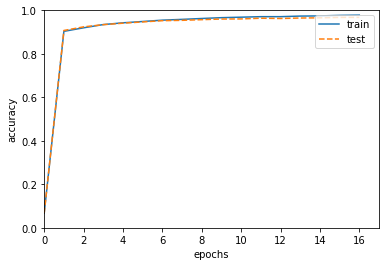

In [45]:
plt.plot(train_acc_list, label='train')
plt.plot(test_acc_list, '--', label='test')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.xlim(0,17)
plt.ylim(0.0,1.0)
plt.legend(loc='upper right')
plt.show()

In [65]:
v = {}
for key, val in network.params.items():
    v[key] = np.zeros_like(val)
v['W1'].shape

(784, 50)